In [6]:
import pandas as pd
import matplotlib.pyplot as plt


CLEANFILE = "../../MLBDATA/Processed/BatterData/ModelingBattingData.csv"

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size':       12,
    'axes.titlesize':  14,
    'axes.labelsize':  12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})
colors = {
    'LHB_actual': '#1b9e77',   # teal
    'RHB_actual': '#d95f02',   # orange
    'LHB_cf':     '#7570b3',   # purple
    'vline':      '0.5'        # medium gray
}

In [ ]:
df = pd.read_csv(CLEANFILE)
df = df[df['bat_side'].isin(['L','R'])]

agg = (
    df
    .groupby(['year','bat_side','cluster'])
    .apply(lambda g: pd.Series({
        'OBP':   (g['on_base_percent'] * g['pa']).sum() / g['pa'].sum(),
        'BABIP': (g['babip']            * g['pa']).sum() / g['pa'].sum(),
    }))
    .reset_index()
)

archetypes = {
    0: 'Contact & Speed Grinders',
    1: 'Fly-Ball Sluggers',
    2: 'Power-Contact Hitters'
}

unique_players = df.drop_duplicates(subset=['last_name, first_name'])

counts = (
    unique_players
    .groupby(['cluster', 'bat_side'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'L': 'LHB_count', 'R': 'RHB_count'})
)

counts['Total'] = counts.sum(axis=1)
counts = counts[['Total', 'LHB_count', 'RHB_count']]

print(df)
print("\nLHB and RHB Counts per Cluster (Unique Players):")
print(counts)

     last_name, first_name  player_id  year  player_age   ab   pa  hit  \
0            cabreramiguel     408234  2015          32  429  511  145   
1             peraltadavid     444482  2015          27  462  517  144   
2          blackmoncharlie     453568  2015          28  614  682  176   
3          maldonadomartín     455117  2015          28  229  256   48   
4          mccutchenandrew     457705  2015          28  566  685  165   
...                    ...        ...   ...         ...  ...  ...  ...   
1385           stottbryson     681082  2024          26  506  571  124   
1386              abramscj     682928  2024          23  541  602  133   
1387           greeneriley     682985  2024          23  512  584  134   
1388          vaughnandrew     683734  2024          26  570  619  140   
1389     pasquantinovinnie     686469  2024          26  496  554  130   

      single  double  triple  ...  groundballs_percent  flyballs_percent  \
0         98      28       1  ...  

C:\Users\Andrew\AppData\Local\Temp\ipykernel_23604\4204224847.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


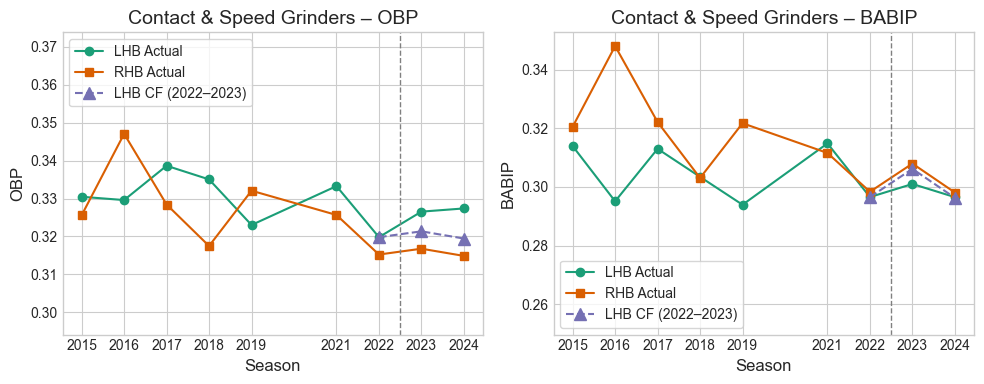

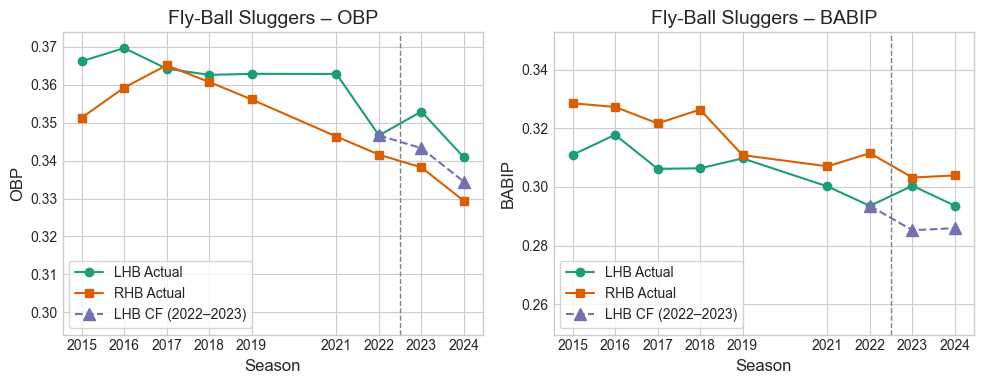

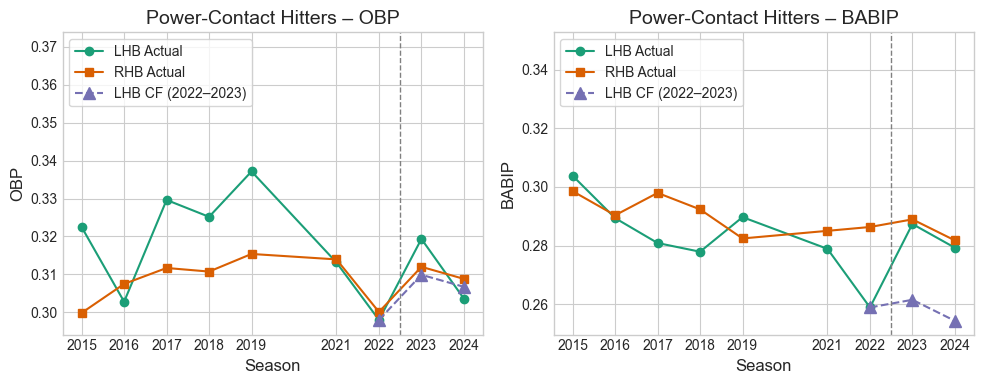


Shift-Ban Effects by Archetype (first ban season = 2023)

               Archetype  OBP_actual   OBP_cf  OBP_diff  BABIP_actual  BABIP_cf  BABIP_diff
Contact & Speed Grinders    0.326551 0.321361  0.005190      0.301012  0.306162   -0.005150
       Fly-Ball Sluggers    0.352911 0.343269  0.009643      0.300418  0.285257    0.015161
   Power-Contact Hitters    0.319358 0.309914  0.009445      0.287378  0.261566    0.025812


In [8]:
baseline_year = 2022
effect_year   = baseline_year + 1   

obp_vals   = []
babip_vals = []

for cl in archetypes:
    tmp = (
        agg[agg['cluster']==cl]
        .pivot(index='year', columns='bat_side', values=['OBP','BABIP'])
        .sort_index()
    )
    b_lo = tmp.loc[baseline_year, ('OBP','L')]
    b_ro = tmp.loc[baseline_year, ('OBP','R')]
    tmp['CF_OBP'] = b_lo + (tmp['OBP']['R'] - b_ro)
    obp_vals += tmp['OBP']['L'].tolist() + tmp['OBP']['R'].tolist() + tmp['CF_OBP'].tolist()

    b_lb = tmp.loc[baseline_year, ('BABIP','L')]
    b_rb = tmp.loc[baseline_year, ('BABIP','R')]
    tmp['CF_BABIP'] = b_lb + (tmp['BABIP']['R'] - b_rb)
    babip_vals += tmp['BABIP']['L'].tolist() + tmp['BABIP']['R'].tolist() + tmp['CF_BABIP'].tolist()

obp_min, obp_max   = min(obp_vals),   max(obp_vals)
pad_obp            = (obp_max - obp_min) * 0.05
ymin_obp, ymax_obp = obp_min - pad_obp, obp_max + pad_obp

babip_min, babip_max   = min(babip_vals),   max(babip_vals)
pad_babip              = (babip_max - babip_min) * 0.05
ymin_babip, ymax_babip = babip_min - pad_babip, babip_max + pad_babip

effects = []
for cl, name in archetypes.items():
    sub = (
        agg[agg['cluster']==cl]
        .pivot(index='year', columns='bat_side', values=['OBP','BABIP'])
        .sort_index()
    )

    base_lo = sub.loc[baseline_year, ('OBP','L')]
    base_ro = sub.loc[baseline_year, ('OBP','R')]
    sub['CF_OBP']    = base_lo + (sub['OBP']['R']    - base_ro)

    base_lb = sub.loc[baseline_year, ('BABIP','L')]
    base_rb = sub.loc[baseline_year, ('BABIP','R')]
    sub['CF_BABIP'] = base_lb + (sub['BABIP']['R'] - base_rb)

    act_obp   = sub['OBP']['L'].loc[effect_year]
    cf_obp    = sub['CF_OBP'].loc[effect_year]
    act_babip = sub['BABIP']['L'].loc[effect_year]
    cf_babip  = sub['CF_BABIP'].loc[effect_year]
    effects.append({
        'Archetype':    name,
        'OBP_actual':   act_obp,
        'OBP_cf':       cf_obp,
        'OBP_diff':     act_obp - cf_obp,
        'BABIP_actual': act_babip,
        'BABIP_cf':     cf_babip,
        'BABIP_diff':   act_babip - cf_babip
    })

    fig, axes = plt.subplots(1,2, figsize=(10,4), sharex=True)
    for i, metric in enumerate(['OBP','BABIP']):
        ax = axes[i]
        ax.plot(sub.index, sub[metric]['L'],
                marker='o', linestyle='-', lw=1.5,
                color=colors['LHB_actual'], label='LHB Actual')
        ax.plot(sub.index, sub[metric]['R'],
                marker='s', linestyle='-', lw=1.5,
                color=colors['RHB_actual'], label='RHB Actual')

        last_two = sub.index[-3:]
        cf_pts   = sub[f'CF_{metric}'].loc[last_two]
        ax.plot(cf_pts.index, cf_pts.values,
                marker='^', linestyle='--', markersize=8,
                color=colors['LHB_cf'],
                label=f'LHB CF ({last_two[0]}–{last_two[1]})')

        ax.axvline(baseline_year + 0.5,
                   color=colors['vline'], linestyle='--', lw=1)

        if metric == 'OBP':
            ax.set_ylim(ymin_obp, ymax_obp)
        else:
            ax.set_ylim(ymin_babip, ymax_babip)

        ax.set_title(f'{name} – {metric}')
        ax.set_ylabel(metric)
        ax.set_xticks(sub.index)
        ax.set_xticklabels(sub.index, rotation=0)
        ax.legend(loc='best', frameon=True)

    for ax in axes:
        ax.set_xlabel('Season')
    fig.tight_layout()
    plt.show()

effects_df = pd.DataFrame(effects)
print(f"\nShift-Ban Effects by Archetype (first ban season = {effect_year})\n")
print(effects_df.to_string(index=False))


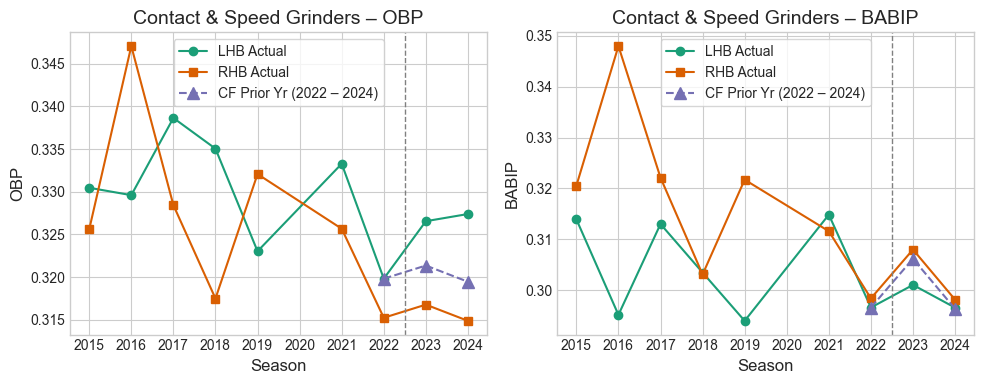

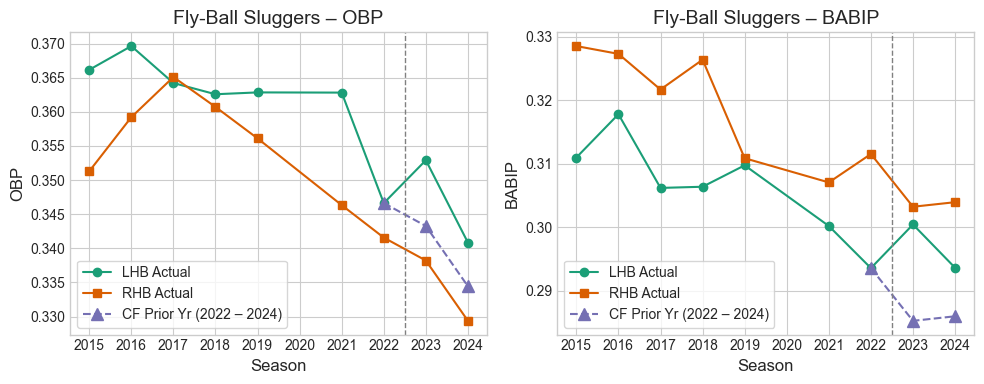

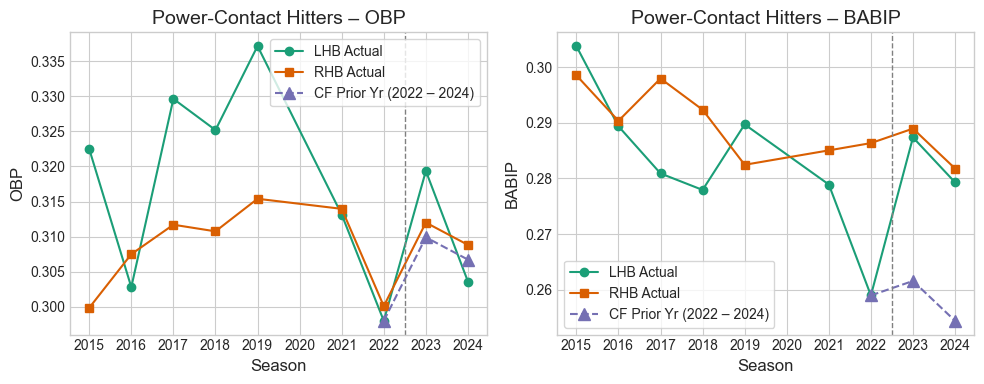


Shift-Ban Effects by Archetype (first ban season = 2023)

               Archetype  OBP_act  OBP_CF_2022  OBP_CF_avg  OBP_diff_2022  OBP_diff_avg  BABIP_act  BABIP_CF_2022  BABIP_CF_avg  BABIP_diff_2022  BABIP_diff_avg
Contact & Speed Grinders 0.326551     0.321361    0.319073       0.005190      0.007478   0.301012       0.306162      0.292513        -0.005150        0.008499
       Fly-Ball Sluggers 0.352911     0.343269    0.346463       0.009643      0.006449   0.300418       0.285257      0.291463         0.015161        0.008955
   Power-Contact Hitters 0.319358     0.309914    0.323874       0.009445     -0.004516   0.287378       0.261566      0.284617         0.025812        0.002761


In [ ]:
baseline_year = 2022
effect_year   = baseline_year + 1

effects = []
for cl, name in archetypes.items():
    sub = (
        agg[agg['cluster'] == cl]
        .pivot(index='year', columns='bat_side', values=['OBP','BABIP'])
        .sort_index()
    )

    lo_base = sub.loc[baseline_year, ('OBP',   'L')]
    ro_base = sub.loc[baseline_year, ('OBP',   'R')]
    lb_base = sub.loc[baseline_year, ('BABIP', 'L')]
    rb_base = sub.loc[baseline_year, ('BABIP', 'R')]

    sub['CF_OBP_base']   = lo_base + (sub['OBP']['R']    - ro_base)
    sub['CF_BABIP_base'] = lb_base + (sub['BABIP']['R'] - rb_base)

    pre = sub.loc[sub.index < baseline_year]
    gap_obp_avg   = (pre['OBP']['L']   - pre['OBP']['R']).mean()
    gap_babip_avg = (pre['BABIP']['L'] - pre['BABIP']['R']).mean()

    sub['CF_OBP_avg']   = sub['OBP']['R']   + gap_obp_avg
    sub['CF_BABIP_avg'] = sub['BABIP']['R'] + gap_babip_avg

    act_obp    = sub['OBP']['L'].loc[effect_year]
    cf_base    = sub['CF_OBP_base'].loc[effect_year]
    cf_avg     = sub['CF_OBP_avg'].loc[effect_year]

    act_babip  = sub['BABIP']['L'].loc[effect_year]
    cfb_base   = sub['CF_BABIP_base'].loc[effect_year]
    cfb_avg    = sub['CF_BABIP_avg'].loc[effect_year]

    effects.append({
        'Archetype':      name,
        'OBP_act':        act_obp,
        'OBP_CF_2022':    cf_base,
        'OBP_CF_avg':     cf_avg,
        'OBP_diff_2022':  act_obp - cf_base,
        'OBP_diff_avg':   act_obp - cf_avg,
        'BABIP_act':      act_babip,
        'BABIP_CF_2022':  cfb_base,
        'BABIP_CF_avg':   cfb_avg,
        'BABIP_diff_2022':act_babip - cfb_base,
        'BABIP_diff_avg': act_babip - cfb_avg,
    })

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    for i, metric in enumerate(['OBP','BABIP']):
        ax = axes[i]
        ax.plot(sub.index, sub[metric]['L'],
                marker='o', linestyle='-', lw=1.5,
                color=colors['LHB_actual'], label='LHB Actual')
        ax.plot(sub.index, sub[metric]['R'],
                marker='s', linestyle='-', lw=1.5,
                color=colors['RHB_actual'], label='RHB Actual')

        last_two = sub.index[-3:]
        cf_base_pts = sub[f'CF_{metric}_base'].loc[last_two]
        ax.plot(cf_base_pts.index, cf_base_pts.values,
                marker='^', linestyle='--', markersize=8,
                color=colors['LHB_cf'],
                label=f'CF Prior Yr (2022 – 2024)')

        ax.axvline(baseline_year + 0.5,
                   color=colors['vline'], linestyle='--', lw=1)

        ax.set_title(f'{name} – {metric}')
        ax.set_ylabel(metric)
        ax.set_xticks(range(2015, 2025))
        ax.set_xticklabels(range(2015, 2025), rotation=0)
        ax.legend(loc='best', frameon=True)

    for a in axes:
        a.set_xlabel('Season')
    fig.tight_layout()
    plt.show()

effects_df = pd.DataFrame(effects)
print(f"\nShift-Ban Effects by Archetype (first ban season = {effect_year})\n")
print(effects_df.to_string(index=False))
